# Workshop 3: Linear Regression and Data Viz

### Basic Analyses 

* View data
* Summary statistics

In [40]:
import pandas as pd 
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [31]:
deaths_16 = pd.read_csv("deaths_16.csv")
print(deaths_16.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2744248 entries, 0 to 2744247
Data columns (total 36 columns):
Unnamed: 0          int64
res_status          int64
education_89        float64
education_03        float64
education_flag      int64
month               int64
sex                 object
detail_age          int64
age_flag            float64
age_recode          int64
age_recode2         int64
age_group           int64
age_infant          float64
death_place         int64
marital             object
day_of_week         int64
data_year           int64
at_work             object
death_manner        float64
burial              object
autopsy             object
activity            float64
injury_place        float64
underlying_cause    object
cause_recode358     int64
cause_recode113     int64
cause_recode130     float64
cause_recode39      int64
multiple_causes     object
race                int64
race_bridged        float64
race_flag           float64
race_recode         int64
ra

In [32]:
deaths_16 = deaths_16.drop(deaths_16.columns[0], axis = 1)
print(deaths_16.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2744248 entries, 0 to 2744247
Data columns (total 35 columns):
res_status          int64
education_89        float64
education_03        float64
education_flag      int64
month               int64
sex                 object
detail_age          int64
age_flag            float64
age_recode          int64
age_recode2         int64
age_group           int64
age_infant          float64
death_place         int64
marital             object
day_of_week         int64
data_year           int64
at_work             object
death_manner        float64
burial              object
autopsy             object
activity            float64
injury_place        float64
underlying_cause    object
cause_recode358     int64
cause_recode113     int64
cause_recode130     float64
cause_recode39      int64
multiple_causes     object
race                int64
race_bridged        float64
race_flag           float64
race_recode         int64
race_recode2        int64
hi

In [35]:
initials = deaths_16['underlying_cause'].astype(str).str[0]
initials = [i in ['*U', 'V', 'W', 'X', 'Y'] for i in initials]
external = deaths_16[(deaths_16['res_status'] != 4) & initials]
print(external.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235194 entries, 11 to 2744163
Data columns (total 35 columns):
res_status          235194 non-null int64
education_89        2316 non-null float64
education_03        232878 non-null float64
education_flag      235194 non-null int64
month               235194 non-null int64
sex                 235194 non-null object
detail_age          235194 non-null int64
age_flag            0 non-null float64
age_recode          235194 non-null int64
age_recode2         235194 non-null int64
age_group           235194 non-null int64
age_infant          1634 non-null float64
death_place         235194 non-null int64
marital             235194 non-null object
day_of_week         235194 non-null int64
data_year           235194 non-null int64
at_work             235194 non-null object
death_manner        233773 non-null float64
burial              235194 non-null object
autopsy             235194 non-null object
activity            228993 non-null float

# Feature Engineering 

Feature engineering is another key step that is closely related to EDA, and again can be a make-or-break step for whether you get useful, interesting results. In feature engineering, you modify existing features ot better reflect reality, or create new features that capture information that is not clear from the existing data. This is a key point where the person doing the analysis adds value through their domain-specific knowledge. 

For example, if the data is marketing data or financial data, use the theory you have learned to think of what relationships you want to capture that is not clear from how the data is currently presented. 

* Discretizing variables automatically coded as continuous
  + ex. Ratings on a scale from 1-5
* Checking variable type - character, numerical, factor
* Log-transforming features like price
* Decomposing existing features
  + ex. separating month from date/time to capture seasonal effects more clearly

In [ ]:
external['edu'] = external['education_03'].fillna(external['education_89'])
external['education'] = pd.cut(external.edu, bins = [0, 2, 3, 5, 8, 9], labels = ["Less than HS", "HS/GED", "Some college", "BA+", "NA"])

def outside_factor(cause):
    sharps_code = ["X" + str(i) for i in range(78, 100)]
    vehicle_code = ["V02", "V03", "V04","V090","V092","V12","V13","V14", "V190", "V192", "V194", "V196", "V83", "V84", "V85", "V86"] + ["V" + str(i) for i in range(20,80)] + ["V803","V804","V805","V810","V811","V820","V821"] + ["V87" + str(i) for i in range(9)] + ["V88" + str(i) for i in range(9)] + ["V890", "V892"]
    if cause in ["W32","W33","W34","X72","X73","X74","*U014","X93","X94","X95"]:
        return "Gun"
    elif cause in ["X40", "X41", "X42", "X43", "X44", "X60", "X61", "X62", "X63", "X64", "X85", "X86", "X87", "X88", "X89", "X90"]:
        return "Drugs"
    elif cause in sharps_code:
        return "Sharps"
    elif cause in vehicle_code:
        return "Vehicle"
    else:
        return "Other"  
external['outside_factor'] = external.underlying_cause.map(outside_factor)

def age(detail):
    digits = str(detail)
    age = int(digits[1:3]) if int(digits[0]) == 1 else (np.nan if detail == 999 else 0)
    if age == 999:
        age = np.nan
    return age
external['age'] = external.detail_age.map(age)
external['young'] = external.age.map(lambda x: 1 if x <= 18 else 0)

def race(row):
    if np.isnan(row['race']):
        return "Unknown"
    race = "Hispanic" if (row['hispanic'] > 199 and row['hispanic'] < 996) else ("White" if row['race'] == 1 else ("Black" if row['race'] == 2 else ("Asian/Pacific Islander" if (row['race'] >= 4 and row['race'] <= 78) else "Native American/Native Alaskan")))
    return race
external['race'] = external.apply(race, axis = 1)

external = external[['month', 'sex', 'age', 'young', 'race', 'hispanic', 'education', 'outside_factor']]
for column in ['sex', 'race', 'education']:
    external[column] = external[column].astype('category')
print(external.info())
print(external.head())

## Avoid P-hacking

One thing to keep in mind as you do this step is to **avoid p-hacking**. P-hacking refers broadly to methods used to manipulate data and get a result that looks significant - e.g., has a p-value < 0.05, hence the name.

If you try every single possible combination of features while doing feature engineering, you may find a combination that seems to be well-correlated with your response variable. However, this may be a spurious correlation, simply due to the sample data you happened to collect. 

This is why using domain knowledge while feature engineering is essential - ideally, only create features for which there is a solid reasoning: first think of the logic of what you are trying to capture, then try to create a feature for it. This is more rigorous than making a few features, then retroactively trying to find explanations for why it may be well correlated. (That being said, people often do the latter in practice.)

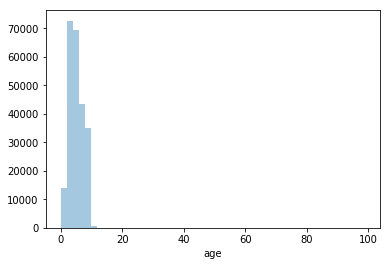

In [60]:
sns.distplot(external.age, kde=False)
plt.show()

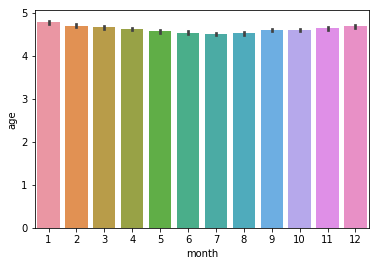

In [62]:
sns.barplot(external.month, external.age)
plt.show()

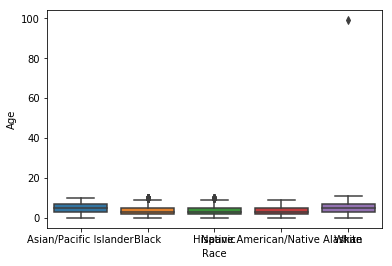

In [63]:
ax_race = sns.boxplot(external.race, external.age)
ax_race.set(xlabel = 'Race', ylabel = 'Age')
plt.show()

In [ ]:
ax_intent = sns.boxplot(external.intent, external.age)
ax_intent.set(xlabel = "Intent", ylabel = "Age")
plt.show()

# General Principles of Modeling

Models can be built for many reasons:
* Express unstructured/alternative data in a form that can be fed into later predictive models (ex. document term matrix, topic model)
* Explanatory - explain relationships between response variable and some features (ex. linear regression)
* Predict some response variable based on some features (ex. gradient boosted model)

In [76]:
lin_reg1 = LinearRegression()
lin_reg1.fit(pd.get_dummies(external.intent), external.age)
print("Coefficients: {0}".format(lin_reg1.coef_))
print("Intercept: {0}".format(lin_reg1.intercept_))
print("Score: {0}".format(lin_reg1.score(pd.get_dummies(external.intent), external.age)))

lin_reg2 = LinearRegression()
lin_reg2.fit(pd.get_dummies(external.sex), external.age)
print("Coefficients: {0}".format(lin_reg2.coef_))
print("Intercept: {0}".format(lin_reg2.intercept_))
print("Score: {0}".format(lin_reg2.score(pd.get_dummies(external.sex), external.age)))

Coefficients: [-0.06662979 -0.12408337 -0.00982011  0.38390811 -0.005605    0.10052049]
Intercept: 4.6160918900362775
Score: 9.82544150743836e-05
Coefficients: [-3.92607951e+12 -3.92607951e+12]
Intercept: 3926079506489.84
Score: 0.03125991815092066
